In [1]:
import os
import glob
import copy
import time
import pickle
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import texttable as tt  
import latextable
import matplotlib.patches as mpatches
from matplotlib.patches import PathPatch
from data_loader import*
from data_preprocessing import*
from evaluation import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2,l1
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
#8_channel_cVEP : 315 test
#256_channel_cVEP : 72 test

In [2]:
# dual-objective CNN (Train history)

category_accuracy = {}
sequence_accuracy = {}
model = 'multi_objective_cnn'
datasets = ['8_channel_cVEP','256_channel_cVEP']
modes = ['within_subject','loso_subject']
for dataset in datasets:
    results_history = {}
    for mode in modes:
        with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
            results = pickle.load(handle)
            results_history[mode] = results
    plot_model_history(results_history, dataset)

In [2]:
# dual-objective CNN (mean results)

model = 'multi_objective_cnn'
datasets = ['8_channel_cVEP','256_channel_cVEP']
modes = ['within_subject','loso_subject']
category_accuracy = {}
sequence_accuracy = {}
precision = {}
recall = {}
f1_score = {}
itr = {}
variable_time_steps = {}
itr_time_steps = {}
for mode in modes:
    category_accuracy[mode] = []
    sequence_accuracy[mode] = []
    precision[mode] = []
    recall[mode] = []
    f1_score[mode] = []
    itr[mode] = []
    
    for dataset in datasets:
        with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
            results = pickle.load(handle)

        category_accuracy[mode] = np.concatenate((category_accuracy[mode],get_mean_results(results,dataset,'category_accuracy')),axis=0)
        sequence_accuracy[mode] = np.concatenate((sequence_accuracy[mode],get_mean_results(results,dataset,'sequence_accuracy')),axis=0)
        precision[mode] = np.concatenate((precision[mode],get_mean_results(results,dataset,'precision')),axis=0)
        recall[mode] = np.concatenate((recall[mode],get_mean_results(results,dataset,'recall')),axis=0)
        f1_score[mode] = np.concatenate((f1_score[mode],get_mean_results(results,dataset,'f1_score')),axis=0)
        itr[mode] = np.concatenate((itr[mode],get_mean_results(results,dataset,'ITR')),axis=0)
        
        mode_data_txt = dataset +'_'+ mode
        variable_time_steps[mode_data_txt] = get_mean_time_steps(results, dataset, mode,model, 'variable_time_steps')
        itr_time_steps[mode_data_txt] = get_mean_time_steps(results, dataset, mode,model,'ITR_time_steps')

cnn_significance_test(category_accuracy,modes) 
boxplot_mean_results(category_accuracy,sequence_accuracy,'accuracy')
boxplot_mean_results(precision,recall,'precision')
boxplot_mean_results(f1_score,itr,'itr')

plot_mean_time_steps(variable_time_steps,itr_time_steps)  

In [2]:
# Comparison (mean results)

models = ['cca', 'eeg2code','inception','multi_objective_cnn']
datasets = ['8_channel_cVEP','256_channel_cVEP']
modes = ['within_subject','loso_subject']
category_accuracy = {}
sequence_accuracy = {}
precision = {}
recall = {}
f1_score = {}
itr = {}
variable_time_steps = {}
itr_time_steps = {}

for dataset in datasets:
    category_accuracy[dataset] = {}
    f1_score[dataset] = {}
    itr[dataset] = {}
    
    variable_time_steps[dataset] = {}
    itr_time_steps[dataset] = {}
    for model in models:
        category_accuracy[dataset][model] = []
        f1_score[dataset][model] = []
        itr[dataset][model] = []
        for mode in modes:
            with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
                results = pickle.load(handle)

            category_accuracy[dataset][model] = np.concatenate((category_accuracy[dataset][model],get_mean_results(results,dataset,'category_accuracy')),axis=0)
            f1_score[dataset][model] = np.concatenate((f1_score[dataset][model],get_mean_results(results,dataset,'f1_score')),axis=0)
            itr[dataset][model] = np.concatenate((itr[dataset][model],get_mean_results(results,dataset,'ITR')),axis=0)

            model_mode_txt = model +'_'+ mode
            if(model=='eeg2code'):
                variable_time_steps_arr = np.zeros((126))
                itr_time_steps_arr = np.zeros((126))
                variable_time_steps_arr[1:] = get_mean_time_steps(results, dataset, mode,model, 'variable_time_steps')
                itr_time_steps_arr[1:] = get_mean_time_steps(results, dataset, mode,model,'ITR_time_steps')
                variable_time_steps[dataset][model_mode_txt] = variable_time_steps_arr
                itr_time_steps[dataset][model_mode_txt] = itr_time_steps_arr
            else:   
                variable_time_steps[dataset][model_mode_txt] = get_mean_time_steps(results, dataset, mode,model, 'variable_time_steps')
                itr_time_steps[dataset][model_mode_txt] = get_mean_time_steps(results, dataset, mode,model,'ITR_time_steps')

comparison_significance_test(category_accuracy, datasets)                
boxplot_comparison_mean_results(category_accuracy['8_channel_cVEP'],category_accuracy['256_channel_cVEP'],'category_accuracy')
boxplot_comparison_mean_results(f1_score['8_channel_cVEP'],f1_score['256_channel_cVEP'],'f1_score')
boxplot_comparison_mean_results(itr['8_channel_cVEP'],itr['256_channel_cVEP'],'ITR')

plot_comparison_time_steps(variable_time_steps['8_channel_cVEP'],variable_time_steps['256_channel_cVEP'],'Category accuracy')  
plot_comparison_time_steps(itr_time_steps['8_channel_cVEP'],itr_time_steps['256_channel_cVEP'],'ITR')

In [2]:
# dual-objective CNN (inidvidual results)

model = 'multi_objective_cnn'
datasets = ['8_channel_cVEP','256_channel_cVEP']
modes = ['within_subject','loso_subject']
category_accuracy = {}
sequence_accuracy = {}
precision = {}
recall = {}
f1_score = {}
itr = {}
for dataset in datasets:
    category_accuracy[dataset] = {}
    sequence_accuracy[dataset] = {}
    precision[dataset] = {}
    recall[dataset] = {}
    f1_score[dataset] = {}
    itr[dataset] = {}
    for mode in modes:
        
        with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
            results = pickle.load(handle)
        
        category_accuracy[dataset][mode] = get_results(results,dataset,'category_accuracy')
        sequence_accuracy[dataset][mode] = get_results(results,dataset,'sequence_accuracy')
        precision[dataset][mode] = get_results(results,dataset,'precision')
        recall[dataset][mode] = get_results(results,dataset,'recall')
        f1_score[dataset][mode] = get_results(results,dataset,'f1_score')
        itr[dataset][mode] = get_results(results,dataset,'ITR')
            
        plot_varaible_time_steps(dataset,mode,results)
        plot_itr_time_steps(dataset,mode,results)
        plot_confusion_matrix(dataset,mode,results)
        plot_roc_curve(results, model, dataset, mode)
        
    boxplot_multi_objective_cnn(category_accuracy,dataset,'category_accuracy')
    boxplot_multi_objective_cnn(sequence_accuracy,dataset,'sequence_accuracy')
    boxplot_multi_objective_cnn(precision,dataset,'precision')
    boxplot_multi_objective_cnn(recall,dataset,'recall')
    boxplot_multi_objective_cnn(f1_score,dataset,'f1_score')
    boxplot_multi_objective_cnn(itr,dataset,'ITR')
      
    

get_latex_table(category_accuracy,sequence_accuracy,precision,recall,f1_score,itr)

In [2]:
# Comparison (inidvidual results)

models = ['cca','eeg2code', 'inception','multi_objective_cnn']
datasets = ['8_channel_cVEP','256_channel_cVEP']
modes = ['within_subject','loso_subject']
category_accuracy = {}
sequence_accuracy = {}
precision = {}
recall = {}
f1_score = {}
itr = {}
results_all = {}
for dataset in datasets:
    category_accuracy[dataset] = {}
    itr[dataset] = {}
    for mode in modes:
        category_accuracy[dataset][mode] = {}
        itr[dataset][mode] = {}
        for model in models:
            fname = './results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode)
            with open(fname, 'rb') as handle:
                results = pickle.load(handle)
            results_all[model] = results
            category_accuracy[dataset][mode][model] = get_results(results,dataset,'category_accuracy')
            itr[dataset][mode][model] = get_results(results,dataset,'ITR')

            plot_comparison_varaible_time_steps(dataset,mode,results_all[model],model)
            plot_comparison_itr_time_steps(dataset,mode,results_all[model],model)
        boxplot_comparison_results(category_accuracy,dataset,mode,'category_acc')
        boxplot_comparison_results(itr,dataset,mode,'ITR')

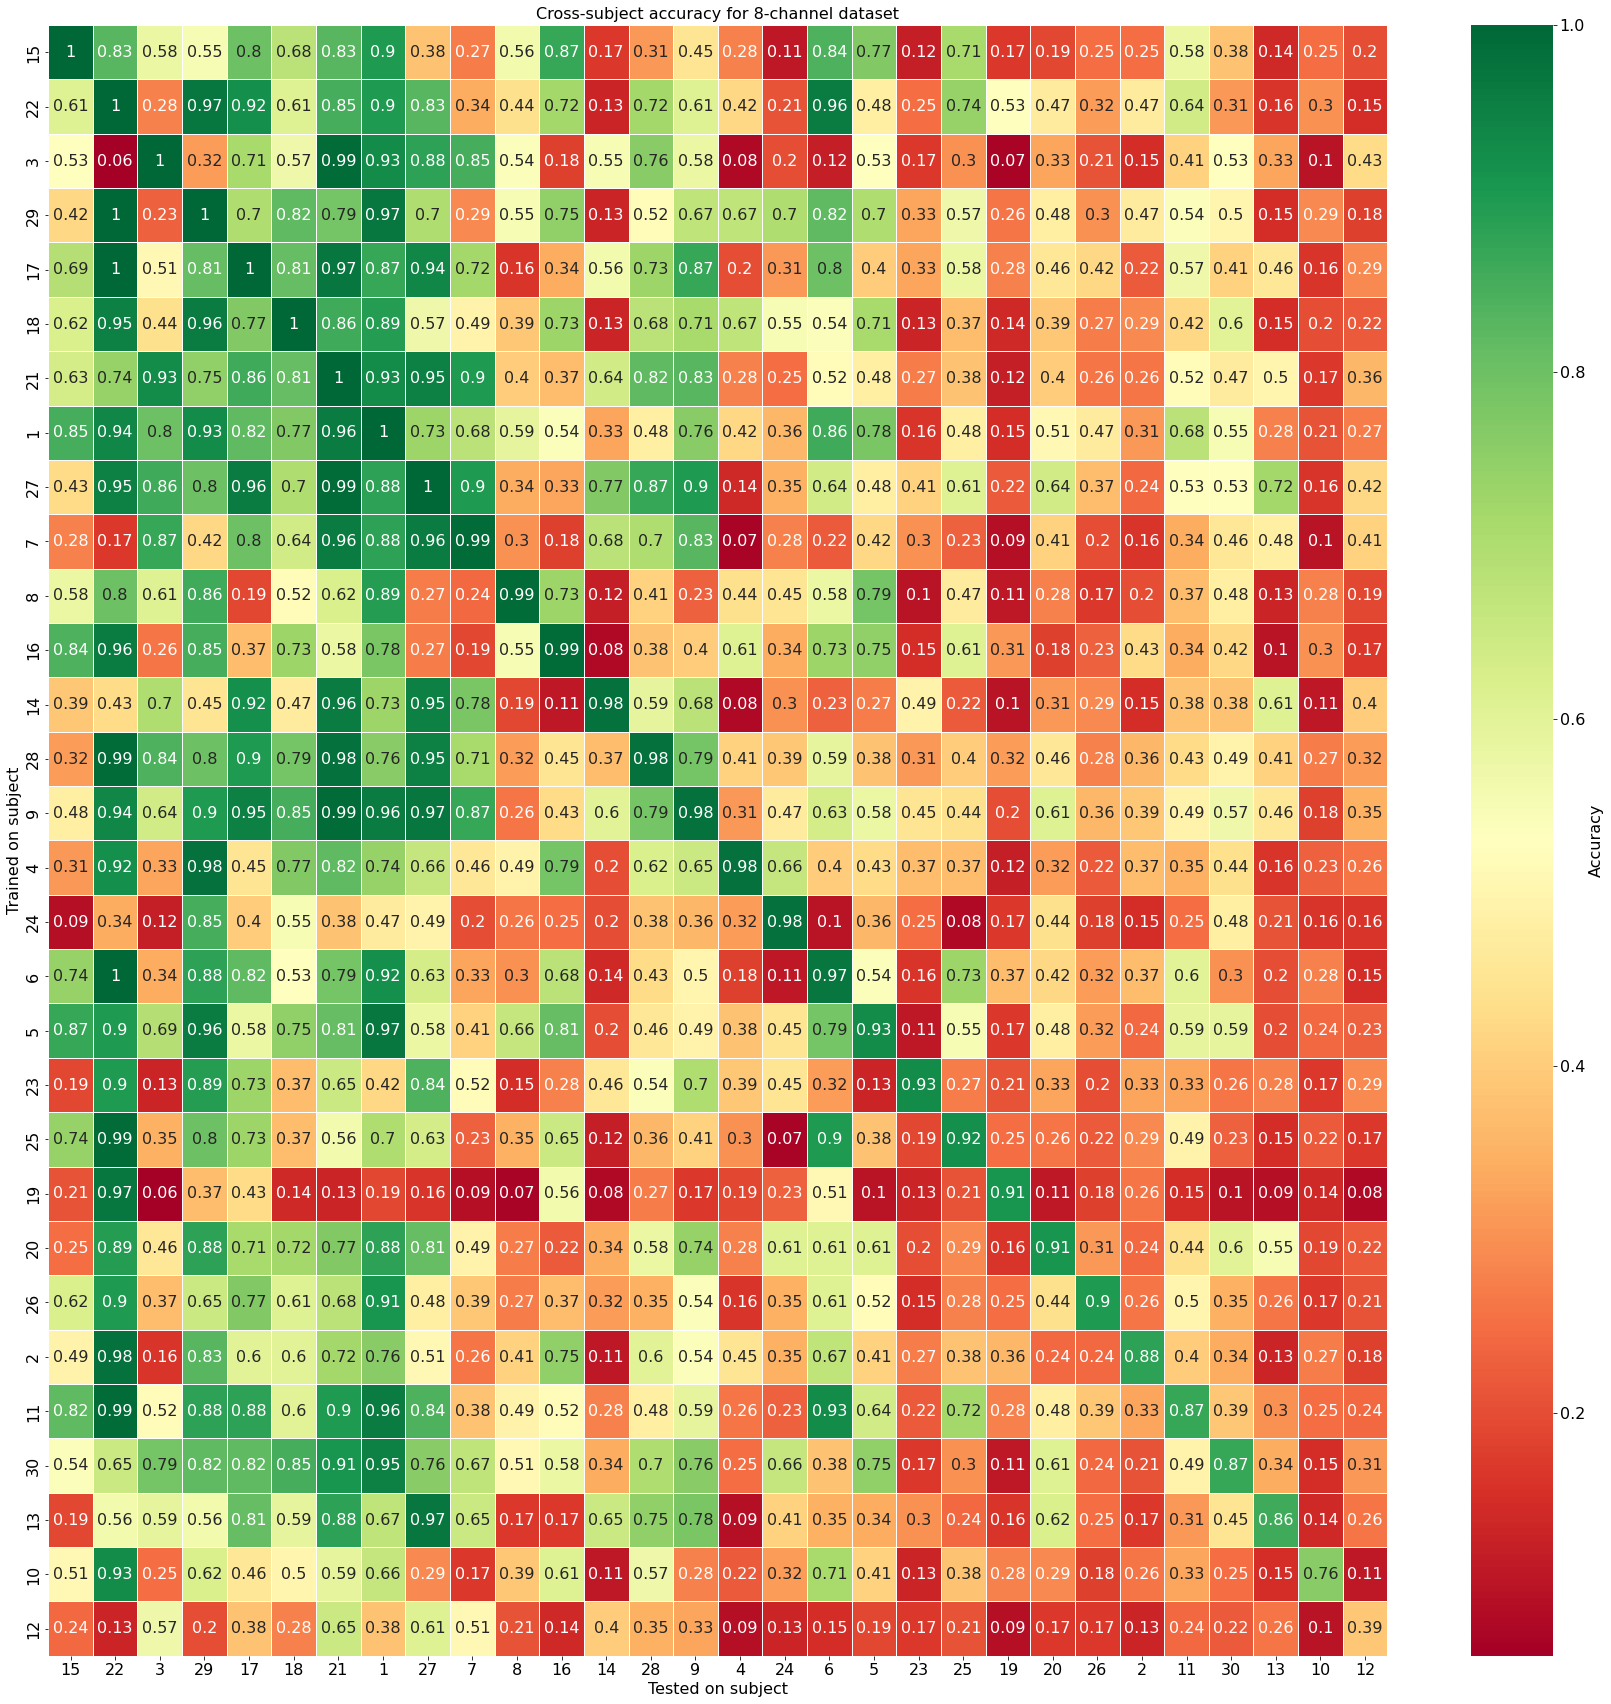

In [64]:
fname = './results/multi_objective_cnn/8_channel_cVEP/cross_subject/multi_objective_cnn_cross_subject.pickle'
with open(fname, 'rb') as handle:
    category_acc = pickle.load(handle)

results = np.zeros((30,30))
for i in range(1,31):
    for j in range(1,31):
        results[i-1][j-1] = np.round(np.array(category_acc[i][j]['category_accuracy']),2)

d = []
for i in range(len(results)):
    d.append(results[i][i])

sort = np.argsort(d)[::-1]

results_new = np.array([]).reshape(0,30)
for i in sort:
    results_new = np.vstack((results_new, results[i][sort][np.newaxis,...]))

fsize = 16
plt.rcParams.update({'font.size': fsize})
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(results_new, linewidth=0.5, annot=True, ax=ax, cmap='RdYlGn',cbar_kws={'label': 'Accuracy'}, yticklabels = sort+1, xticklabels = sort+1)
ax.set_title('Cross-subject accuracy for 8-channel dataset',fontsize=fsize)
ax.set_xlabel('Tested on subject')
ax.set_ylabel('Trained on subject')
plt.show()

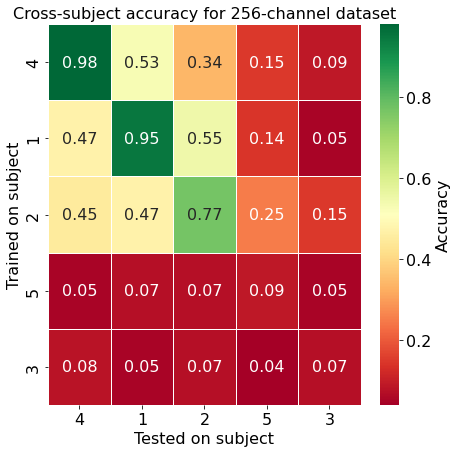

In [67]:
fname = './results/multi_objective_cnn/256_channel_cVEP/cross_subject/multi_objective_cnn_cross_subject.pickle'
with open(fname, 'rb') as handle:
    category_acc = pickle.load(handle)

results = np.zeros((5,5))
for i in range(1,6):
    for j in range(1,6):
        results[i-1][j-1] = np.round(np.array(category_acc[i][j]['category_accuracy']),2)

d = []
for i in range(len(results)):
    d.append(results[i][i])

sort = np.argsort(d)[::-1]

results_new = np.array([]).reshape(0,5)
for i in sort:
    results_new = np.vstack((results_new, results[i][sort][np.newaxis,...]))

fsize = 16
plt.rcParams.update({'font.size': fsize})
fig, ax = plt.subplots(figsize=(7,7)) 
sns.heatmap(results_new, linewidth=0.5, annot=True, ax=ax, cmap='RdYlGn',cbar_kws={'label': 'Accuracy'}, yticklabels = sort+1, xticklabels = sort+1)
ax.set_title('Cross-subject accuracy for 256-channel dataset',fontsize=fsize)
ax.set_xlabel('Tested on subject')
ax.set_ylabel('Trained on subject')
plt.show()

In [68]:
from multi_objective_cnn import *
def run_dynamic_stopping_scatter(dataset):
    model = 'multi_objective_cnn'
    mode = 'loso_subject'
    if(model=='multi_objective_cnn'):
        model_txt = 'Multi-objective CNN'

    with open('./datasets/{}.pickle'.format(dataset), 'rb') as handle:
        data = pickle.load(handle)

    X = data['X']
    Ys = data['Ys']
    Yt = data['Yt'] 

    if(dataset=='8_channel_cVEP'):
        n_subjects = 30
        n_classes = 21
        n_channels = 8
        mat = scipy.io.loadmat('./datasets/8_channel_cVEP/resources/mgold_61_6521_flip_balanced_20.mat')
        codes = mat['codes'].astype('float32')
        codebook = np.moveaxis(codes,1,0).astype('float32')

        X_new_c = np.reshape(X[:,:100],(30,100*15,504,8))
        Ys_new_c = Ys[:,:100]
        Yt_new_c = Yt[:,:100]

        Ys_new_c = np.repeat(Ys_new_c,15,axis=1)
        Yt_new_c = np.repeat(Yt_new_c,15,axis=1)

        X_new_nc = np.reshape(X[:,100:,:504,:],(30,75,504,8))
        Ys_new_nc = Ys[:,100:]
        Yt_new_nc = Yt[:,100:]

        X = np.concatenate((X_new_c, X_new_nc),axis=1)
        Ys = np.concatenate((Ys_new_c, Ys_new_nc),axis=1)
        Yt = np.concatenate((Yt_new_c, Yt_new_nc),axis=1)

    if(dataset=='256_channel_cVEP'):
        n_subjects = 5
        n_classes = 36
        n_channels = 256
        codebook = np.load('./datasets/256_channel_cVEP/Scripts/codebook_36t.npy')[:n_classes]
        codes = np.moveaxis(codebook,1,0)
        X, rejected_chans = remove_bad_channels(X)

        X = np.reshape(X,(5,108*2,504,256))

        Ys = np.repeat(Ys,2,axis=1)
        Yt = np.repeat(Yt,2,axis=1)


    # Preprocessing data
    low_cutoff = 2
    high_cutoff = 30
    sfreq = 240
    X = bandpass_filter_data(X, low_cutoff, high_cutoff, sfreq)

    acc_scatter_all = np.zeros((n_subjects,22))
    time_scatter_all = np.zeros((n_subjects,22))
    for i in range(0,n_subjects):
        X_new = X[i]
        ys_new = Ys[i]
        yt_new = Yt[i]

        y_new= np.concatenate((yt_new[..., np.newaxis],ys_new), axis=1)

        if dataset == '8_channel_cVEP':
            X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.4,stratify=y_new[:,0], shuffle= True)
            X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2,stratify=y_test[:,0], shuffle= True)
        else:
            X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.6,stratify=y_new[:,0], shuffle= True)
            X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3,stratify=y_test[:,0], shuffle= True)
        X_val = standardize_data(X_val)
        X_test = standardize_data(X_test)

        ys_val = y_val[:,1:]
        ys_test = y_test[:,1:]

        yt_val = y_val[:,0]
        yt_test = y_test[:,0]

        yt_val = to_categorical(yt_val)
        yt_test = to_categorical(yt_test)

        multi_objective_cnn_model = build_multi_objective_cnn_model(n_channels,n_classes)
        checkpoint_filepath = './saved_models/{}/{}/{}/S{}/'.format(model,dataset,mode,i+1)
        multi_objective_cnn_model.load_weights(checkpoint_filepath).expect_partial()

        loss, _,_, seq_accuracy, category_accuracy = multi_objective_cnn_model.evaluate(x = X_test, y = {"sequence": ys_test,"category": yt_test}, verbose=0) 

        print('Dynamic stopping on subject {}'.format(i+1))

        indices = np.arange(0,n_classes)
        dynamic_pred_acc = []
        acc_scatter = []
        time_scatter = []
        for k in range(0,X_test.shape[1]+1,24):
            X_test_new = X_test.copy()
            X_test_new[:,k:,:] = 0 
            _, pred = multi_objective_cnn_model.predict(X_test_new)

            prediction = np.argmax(pred,axis=1)
            prediction_conf = np.max(pred,axis=1)
            target = np.argmax(yt_test,axis=1)

            acc_scatter.append(np.mean(prediction==target))
            time_scatter.append(k/240)

        acc_scatter_all[i] = np.array(acc_scatter)
        time_scatter_all[i] = np.array(time_scatter)
    return acc_scatter_all, time_scatter_all

In [69]:
acc8, time8 = run_dynamic_stopping_scatter('8_channel_cVEP')

Dynamic stopping on subject 1
Dynamic stopping on subject 2
Dynamic stopping on subject 3
Dynamic stopping on subject 4
Dynamic stopping on subject 5
Dynamic stopping on subject 6
Dynamic stopping on subject 7
Dynamic stopping on subject 8
Dynamic stopping on subject 9
Dynamic stopping on subject 10
Dynamic stopping on subject 11
Dynamic stopping on subject 12
Dynamic stopping on subject 13
Dynamic stopping on subject 14
Dynamic stopping on subject 15
Dynamic stopping on subject 16
Dynamic stopping on subject 17
Dynamic stopping on subject 18
Dynamic stopping on subject 19
Dynamic stopping on subject 20
Dynamic stopping on subject 21
Dynamic stopping on subject 22
Dynamic stopping on subject 23
Dynamic stopping on subject 24
Dynamic stopping on subject 25
Dynamic stopping on subject 26
Dynamic stopping on subject 27
Dynamic stopping on subject 28
Dynamic stopping on subject 29
Dynamic stopping on subject 30


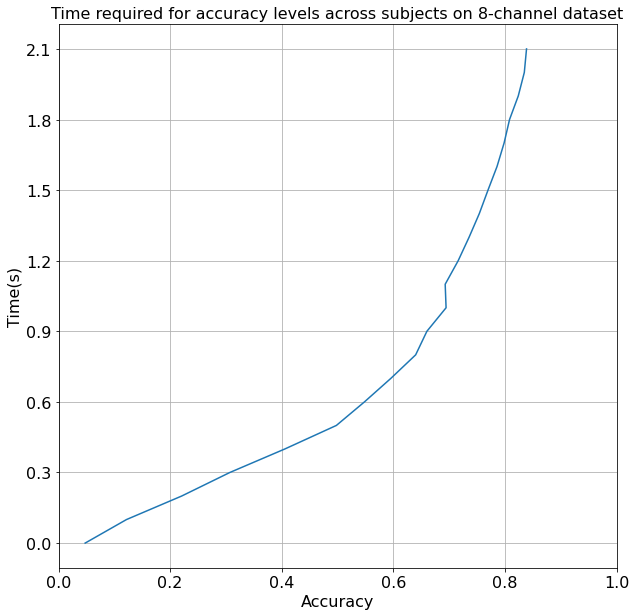

In [94]:
acc_levels = np.mean(acc8,axis=0)
time_levels = np.mean(time8,axis=0)

fsize = 16
plt.rcParams.update({'font.size': fsize})
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(acc_levels,time_levels)
ax.set_xticks(np.arange(0,1.1,0.2))
ax.set_yticks(np.arange(0,2.2,0.3))
ax.grid(False)
ax.grid(True)
ax.set_xlabel('Accuracy',fontsize=fsize)
ax.set_ylabel('Time(s)',fontsize=fsize)
ax.set_title("Time required for accuracy levels across subjects on 8-channel dataset",fontsize=fsize)
plt.show()